# Ratings Prediction Project

###### This project is related a website where people write different reviews for technical products. Now a new feature has been added to website i.e., the reviewer will have to add stars(rating) as well with the review. The rating is out 5 stars and it only has 5 options available 1 star, 2 stars, 3 stars, 4 stars, 5 stars. Now the requirement is to predict ratings for the reviews which were written in the past for which website don’t have a rating. So, we have to build an application which can predict the rating by seeing the review.

In [282]:

# Let's import the required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from collections import Counter

import warnings 
warnings.filterwarnings('ignore')

# Data Acquisition

In [283]:
df1=pd.read_csv('amazon_flipkart_reviews.csv')
df1

,Unnamed: 0,Unnamed: 0.1,reviews,ratings
0,0,0.0,Disclaimer: I am an I.T. network person at a l...,5
1,1,1.0,I bought the NETGEAR AX6600 to upgrade my old ...,1
2,2,2.0,I bought this to upgrade my older nighthawk r8...,1
3,3,3.0,This router replaced a great R7800 router whic...,5
4,4,4.0,Router #1 I received from the pre-order had a ...,1
...,...,...,...,...
99774,99774,NaN,Overall Mobile is excellent...to our childrens...,5
99775,99775,NaN,Good smartphone for medium usage.,5
99776,99776,NaN,It's batter to buy stock android over ads and ...,5
99777,99777,NaN,Nice phone at given price..,5


In [284]:
#Dropping unnecessary column
df1.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [288]:
#checking shape of train dataset
print ('Shape =',df1.shape)

Shape = (99779, 2)


* The given dataset contains 99779 rows & 2 column

In [289]:
#checking features name
print("Features/Columns :\n", df1.columns)

Features/Columns :
 Index(['reviews', 'ratings'], dtype='object')


In [290]:
#checking information of the datset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99779 entries, 0 to 99778
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  99777 non-null  object
 1   ratings  99779 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


* There are two features & both are of object type

In [292]:
#checking for values
df1.isnull().sum()

reviews    2
ratings    0
dtype: int64


* Non-Null Count suggests that some null values are present.

<AxesSubplot:>

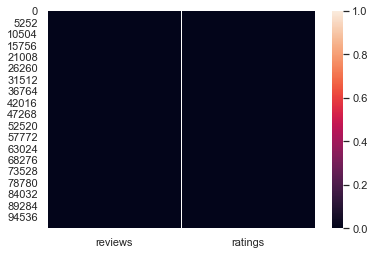

In [293]:
#checking for null values via visualisation
sns.heatmap(df1.isnull())

In [294]:
#dropping null values
df1.dropna(inplace=True)

In [295]:
#checking va;ue colunt for rating 
df1['ratings'].value_counts()

5       60632
4       18559
1       10690
3        6331
2        3549
Null       16
Name: ratings, dtype: int64

In [296]:
df1.drop(df1[df1['ratings']=='Null'].index,inplace=True,axis=0)

In [297]:
#converting rating into int datatype
df1['ratings']=df1['ratings'].astype(int)

<AxesSubplot:xlabel='ratings', ylabel='count'>

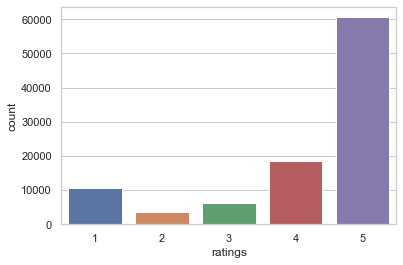

In [298]:
import seaborn as sb
sb.countplot(x='ratings',data=df1)

* We notice that the data is highly imbalanced

In [277]:
#seperating records according to ratings and finding which rating has minimum number of records.
length_of_records = {}
df_ratings_record = {}
for r in ['1','2','3','4','5']:
    length_of_records[r] = len(df1[df1['ratings']==r])
    df_ratings_record[r] = df1[df1['ratings']==r]
    
min_ratings_record = min(length_of_records, key=length_of_records.get)
print(f"Minimum number of records among ratings are for: {min_ratings_record} :: {length_of_records[min_ratings_record]}")

#Taking out records in equal portion as accordance with minimum number of records.
lor = length_of_records[min_ratings_record]     #length of minimum number of records.

df = pd.concat([
    df_ratings_record['1'][:lor],
    df_ratings_record['2'][:lor],
    df_ratings_record['3'][:lor],
    df_ratings_record['4'][:lor],
    df_ratings_record['5'][:lor],
    
], ignore_index=True, sort=False)



df

Minimum number of records among ratings are for: 2 :: 3549


,reviews,ratings
0,I bought the NETGEAR AX6600 to upgrade my old ...,1
1,I bought this to upgrade my older nighthawk r8...,1
2,Router #1 I received from the pre-order had a ...,1
3,This is a great router all around. The reason ...,1
4,"They should be paying you!, for having to deal...",1
...,...,...
17740,Great product for the price. Put this on our m...,5
17741,I used it for my 2005 38 foot expedition motor...,5
17742,Product was as advertised Liked them a lot. Ni...,5
17743,So far works well,5


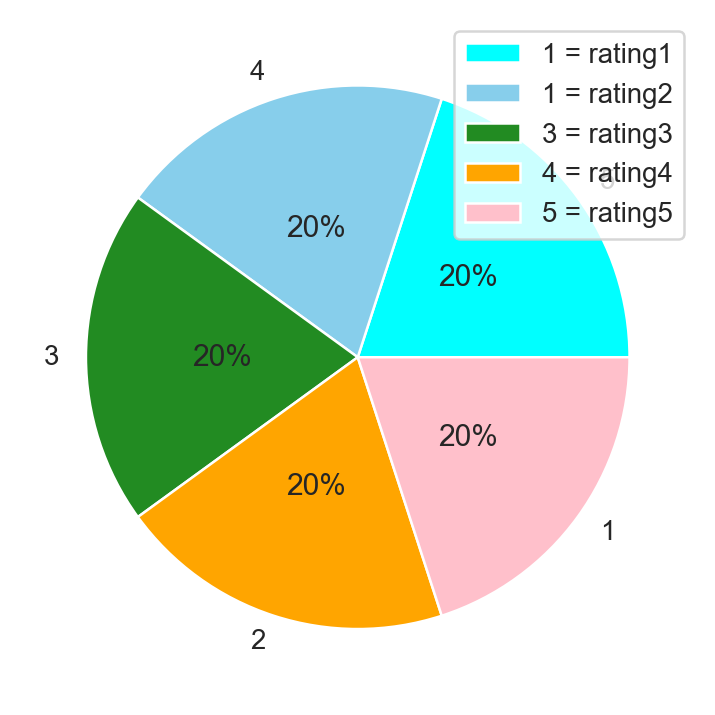

In [300]:
lb=df['ratings'].value_counts().index.tolist()
val=df['ratings'].value_counts().values.tolist()

clr=('cyan','skyblue','forestgreen','orange','pink')
plt.figure(figsize=(7,5),dpi=180)
sns.set_context('talk',font_scale=0.2)
sns.set(style='whitegrid')
plt.pie(x=val,labels=lb,colors=clr,autopct='%2.0f%%',pctdistance=0.5,radius=1)
plt.legend(["1 = rating1",'1 = rating2','3 = rating3','4 = rating4','5 = rating5'])
plt.show()

In [227]:
#New columns for checking length of reviews column
df['length_reviews'] = df.reviews.str.len()
df.head()

,reviews,ratings,length_reviews
0,I bought the NETGEAR AX6600 to upgrade my old ...,1,2235
1,I bought this to upgrade my older nighthawk r8...,1,499
2,Router #1 I received from the pre-order had a ...,1,639
3,This is a great router all around. The reason ...,1,589
4,"They should be paying you!, for having to deal...",1,2081


In [228]:
#converting all the text to lower form
df['reviews'] = df.reviews.str.lower()

In [229]:
# function to filter using POS tagging. This will be called inside the below function
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning.
def Processed_data(Review):
    # Replace email addresses with 'email'
    Review=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', Review)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    Review=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',Review)
        
    # getting only words(i.e removing all the special characters)
    Review = re.sub(r'[^\w]', ' ', Review) 
        
    # getting only words(i.e removing all the" _ ")
    Review = re.sub(r'[\_]', ' ', Review) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    Review=re.sub(r'\s+[a-zA-Z]\s+', ' ', Review)
    
    # Removing extra whitespaces
    Review=re.sub(r'\s+', ' ', Review)

    #converting all the letters of the review into lowercase
    Review = Review.lower()
    
    # splitting every words from the sentences
    Review = Review.split()

    # iterating through each words and checking if they are stopwords or not,
    Review=[word for word in Review if not word in set(STOPWORDS)]
    
    # remove empty tokens
    Review = [text for text in Review if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(Review)

    # considering words having length more than 3only
    Review = [text for text in Review if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS
    Review = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    Review = [text for text in Review if len(text) > 3]
    Review = ' '.join(Review)
    return Review

In [230]:
df['clean_reviews']=df['reviews'].apply(Processed_data)

In [231]:
#again making new column to check the length after preprocessing
df['clean_reviews_length']=df.clean_reviews.str.len()


df.head(10)

,reviews,ratings,length_reviews,clean_reviews,clean_reviews_length
0,i bought the netgear ax6600 to upgrade my old ...,1,2235,bought netgear ax6600 upgrade almond router al...,1158
1,i bought this to upgrade my older nighthawk r8...,1,499,bought upgrade nighthawk r8000 huge mistake 80...,203
2,router #1 i received from the pre-order had a ...,1,639,router received order loose connection power i...,350
3,this is a great router all around. the reason ...,1,589,great router reason gave star deception want n...,219
4,"they should be paying you!, for having to deal...",1,2081,paying having deal incomplete product started ...,1016
5,i probably should have done more research. the...,1,3528,probably research horror story problem bridge ...,1619
6,i purchased 2 units - one for home and one for...,1,1948,purchased unit home cottage cottage configured...,1101
7,if i could give it no stars i would. device la...,1,479,star device lasted month started drop connecti...,200
8,"i upgraded the firmware to 1.0.7.04_20190215, ...",1,1503,upgraded firmware 20190215 rebooted verified f...,736
9,linksys used to be a reputable company a long ...,1,497,linksys reputable company long time expected s...,261


In [232]:
# Total length removal from headline 
print ('Origian Length', df.length_reviews.sum())
print ('Clean Length', df.clean_reviews_length.sum())
print('Total Reduction = ',df['length_reviews'].sum()-df['clean_reviews_length'].sum())

Origian Length 12847468
Clean Length 6451443
Total Reduction =  6396025


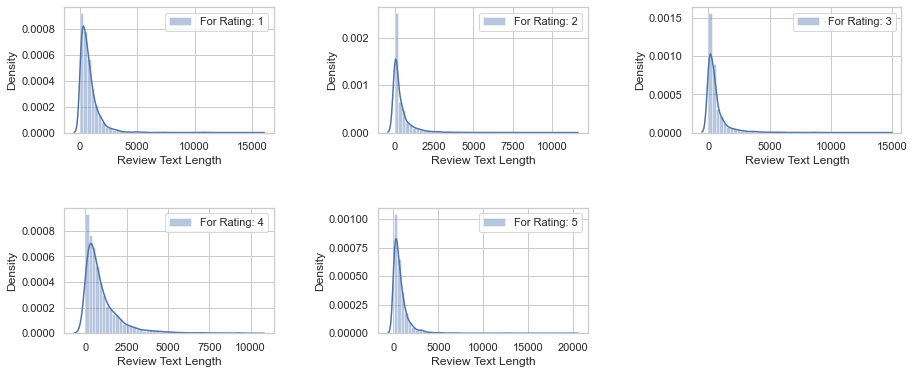

In [233]:

#checking review text length distribution for each rating
ratings = np.sort(df.ratings.unique())
cols = 3
rows = len(ratings)//cols
if rows % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace=0.6, wspace=0.5)
p = 1

for i in ratings:
    axis = fig.add_subplot(rows,cols,p)
    sns.distplot(df.length_reviews[df.ratings==i],ax=axis,label=f"For Rating: {i}")
    axis.set_xlabel(f"Review Text Length")
    axis.legend()
    p += 1
    
plt.show()

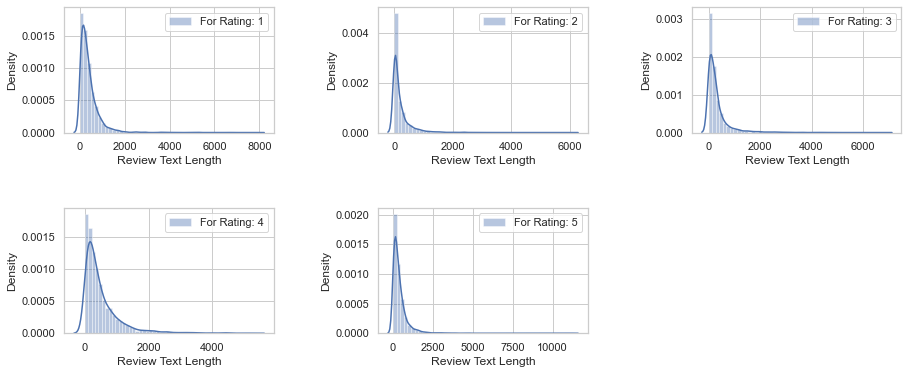

In [234]:
#checking review text length distribution for each rating after cleaning
ratings = np.sort(df.ratings.unique())
cols = 3
rows = len(ratings)//cols
if rows % cols != 0:
    rows += 1
    
fig = plt.figure(figsize=(15,6))
plt.subplots_adjust(hspace=0.6, wspace=0.5)
p = 1

for i in ratings:
    axis = fig.add_subplot(rows,cols,p)
    sns.distplot(df.clean_reviews_length[df.ratings==i],ax=axis,label=f"For Rating: {i}")
    axis.set_xlabel(f"Review Text Length")
    axis.legend()
    p += 1
    
plt.show()

* Review text length reduced by almost 5000 characters 

******************Rating 1 *************************


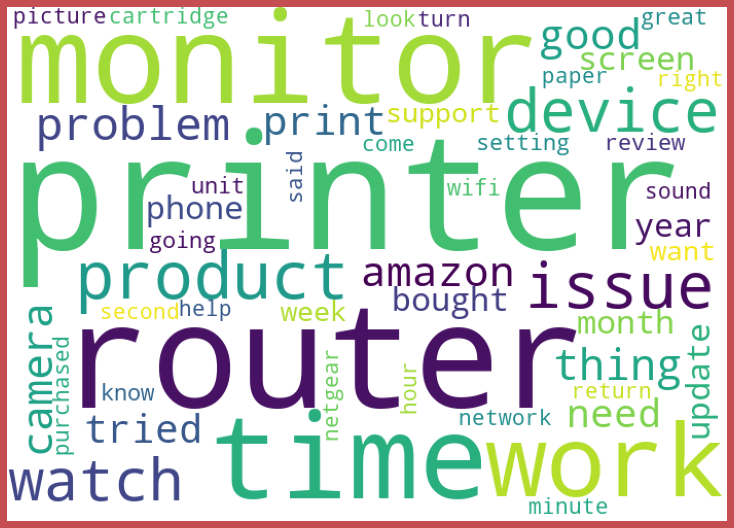

******************Rating 2 *************************


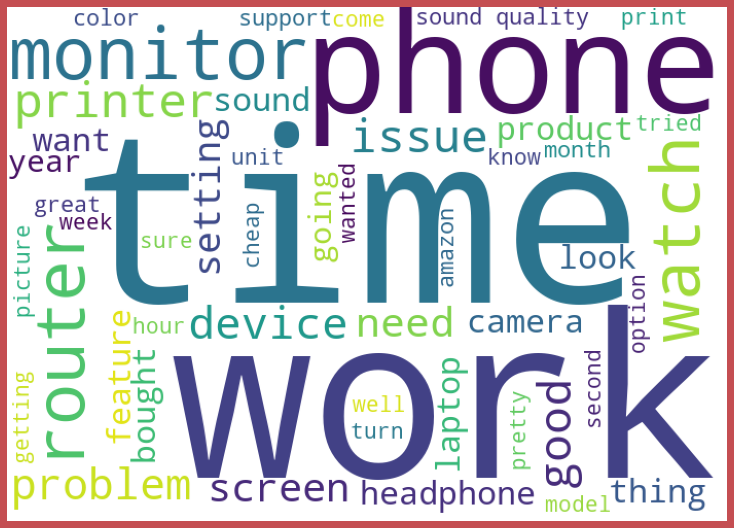

******************Rating 3 *************************


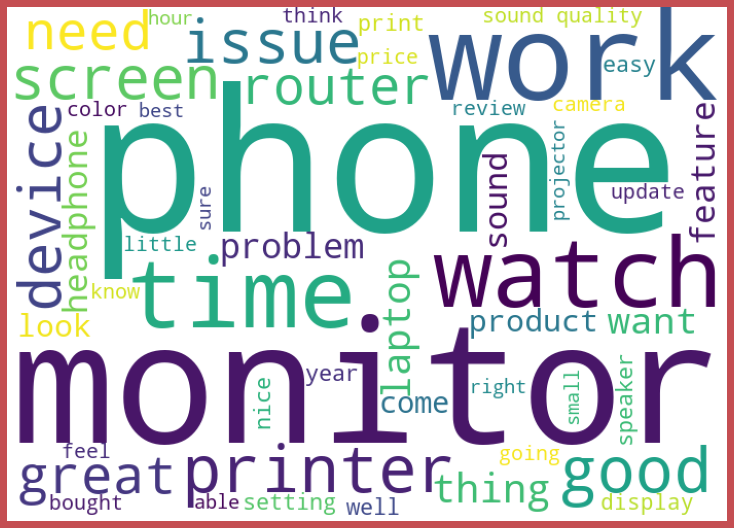

******************Rating 4 *************************


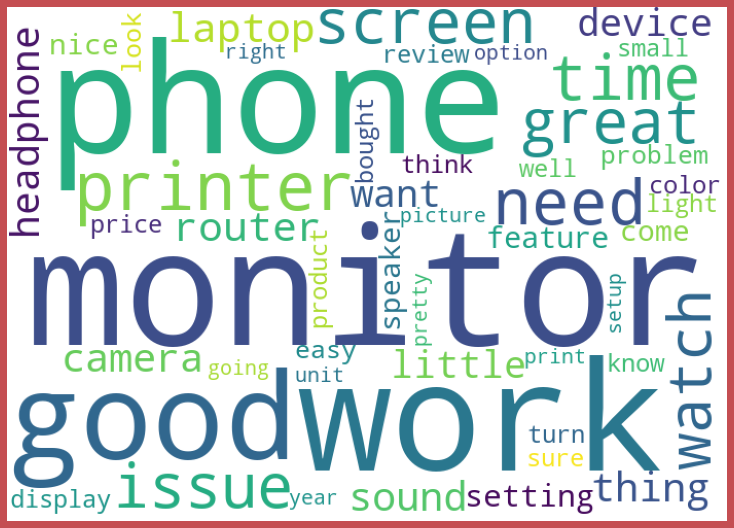

******************Rating 5 *************************


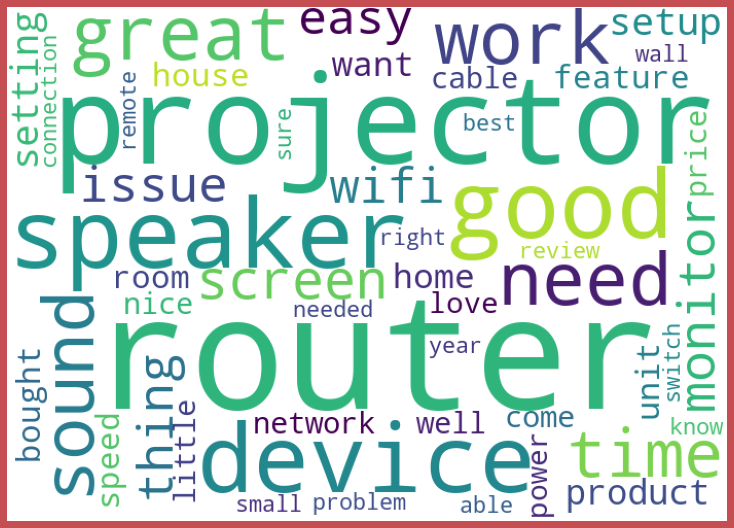

In [235]:
#Getting sense of loud words in reviews for each rating
from wordcloud import WordCloud

for i in [1,2,3,4,5]:
    print('******************Rating',i,'*************************')
    
    reviews = df['clean_reviews'][df['ratings']==i]

    reviews_cloud = WordCloud(width=700,height=500,background_color='white',max_words=50).generate(' '.join(reviews))

    plt.figure(figsize=(10,8),facecolor='r')
    plt.imshow(reviews_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

In [236]:
from collections import Counter
#counting frequently occurence of words in review
count1 = Counter(" ".join(df[df['ratings']==5]["reviews"]).split()).most_common(50)
count2 = Counter(" ".join(df[df['ratings']==4]["reviews"]).split()).most_common(50)
count3 = Counter(" ".join(df[df['ratings']==3]["reviews"]).split()).most_common(50)
count4 = Counter(" ".join(df[df['ratings']==2]["reviews"]).split()).most_common(50)
count5 = Counter(" ".join(df[df['ratings']==1]["reviews"]).split()).most_common(50)
dataframe=pd.DataFrame()
print("TOP 50 Words in Each Category (Word,Counts)")
dataframe['Most Frequent Words in 5 star rating']=count1
dataframe['Most Frequent Words in 4 star rating']=count2
dataframe['Most Frequent Words in 3 star rating']=count3
dataframe['Most Frequent Words in 2 star rating']=count4
dataframe['Most Frequent Words in 1 star rating']=count5
dataframe

TOP 50 Words in Each Category (Word,Counts)


,Most Frequent Words in 5 star rating,Most Frequent Words in 4 star rating,Most Frequent Words in 3 star rating,Most Frequent Words in 2 star rating,Most Frequent Words in 1 star rating
0,"(the, 25903)","(the, 35634)","(the, 20000)","(the, 13278)","(the, 25825)"
1,"(and, 14879)","(to, 18713)","(to, 10807)","(to, 7541)","(to, 16368)"
2,"(to, 14447)","(i, 17744)","(i, 10059)","(i, 7173)","(i, 15687)"
3,"(i, 14402)","(a, 16951)","(and, 9487)","(and, 6801)","(and, 13580)"
4,"(a, 12455)","(and, 16519)","(a, 8889)","(a, 5672)","(a, 11944)"
5,"(it, 8514)","(it, 11716)","(is, 7811)","(is, 5345)","(it, 10324)"
6,"(is, 8179)","(is, 11536)","(it, 7103)","(it, 4890)","(this, 7485)"
7,"(this, 6859)","(for, 8781)","(for, 5281)","(this, 3594)","(is, 7279)"
8,"(for, 6429)","(of, 8466)","(of, 4885)","(of, 3386)","(of, 6555)"
9,"(of, 6191)","(this, 7348)","(this, 4772)","(for, 3353)","(for, 5553)"


# After cleaning

In [237]:
from collections import Counter
#counting frequently occurence of words in review after preprocessing
count1 = Counter(" ".join(df[df['ratings']==5]["clean_reviews"]).split()).most_common(20)
count2 = Counter(" ".join(df[df['ratings']==4]["clean_reviews"]).split()).most_common(20)
count3 = Counter(" ".join(df[df['ratings']==3]["clean_reviews"]).split()).most_common(20)
count4 = Counter(" ".join(df[df['ratings']==2]["clean_reviews"]).split()).most_common(20)
count5 = Counter(" ".join(df[df['ratings']==1]["clean_reviews"]).split()).most_common(20)
dataframe=pd.DataFrame()
print("TOP 50 Words in Each Category (Word,Counts)")
dataframe['Most Frequent Words in 5 star rating']=count1
dataframe['Most Frequent Words in 4 star rating']=count2
dataframe['Most Frequent Words in 3 star rating']=count3
dataframe['Most Frequent Words in 2 star rating']=count4
dataframe['Most Frequent Words in 1 star rating']=count5
dataframe

TOP 50 Words in Each Category (Word,Counts)


,Most Frequent Words in 5 star rating,Most Frequent Words in 4 star rating,Most Frequent Words in 3 star rating,Most Frequent Words in 2 star rating,Most Frequent Words in 1 star rating
0,"(router, 3586)","(good, 2715)","(good, 2775)","(good, 1579)","(printer, 2925)"
1,"(sound, 1955)","(monitor, 2274)","(phone, 1493)","(phone, 1279)","(router, 2399)"
2,"(great, 1894)","(like, 2216)","(like, 1417)","(quality, 978)","(time, 1971)"
3,"(projector, 1806)","(work, 2149)","(work, 1267)","(sound, 890)","(work, 1786)"
4,"(good, 1758)","(phone, 2087)","(sound, 1245)","(work, 884)","(monitor, 1625)"
5,"(speaker, 1597)","(great, 1817)","(quality, 1219)","(like, 874)","(product, 1340)"
6,"(device, 1594)","(printer, 1667)","(time, 1059)","(time, 863)","(support, 1307)"
7,"(work, 1517)","(sound, 1609)","(watch, 1045)","(product, 805)","(print, 1268)"
8,"(wifi, 1408)","(watch, 1517)","(monitor, 994)","(battery, 763)","(watch, 1180)"
9,"(easy, 1384)","(time, 1514)","(printer, 928)","(watch, 668)","(issue, 1174)"


In [238]:
# Tokenizing Documents..
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(df['clean_reviews']):
    a=word_tokenize(i,'english')
    data.append(a)

In [239]:

# Making Word dictionary...
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(25043 unique tokens: ['almond', 'amazon', 'ax6600', 'background', 'barrier']...)


##### Convert Text into Vectors

In [240]:
# 1. Convert text into vectors using TF-IDF
# 3. Split feature and label
tf_vec = TfidfVectorizer()
features = tf_vec.fit_transform(df['clean_reviews'])



(17743, 25040)

##### Seperating Input and Output variables

In [302]:

X = features
y = df['ratings']
print(X.shape)


(17743, 25040)


In [241]:
# Libraries for training

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Ensemble Techniques

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model selection libraries
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV

# Mmetrics to evaluate our model performance 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score

# Creating instances

RF=RandomForestClassifier()
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
AD=AdaBoostClassifier()
XG=XGBClassifier(eval_metric='mlogloss')

In [242]:
# List of Models
models=[]
models.append(('MultinomialNB()',MNB))
models.append(('DecisionTreeClassifier',DT))
models.append(('RandomForestClassifier',RF))
models.append(('AdaBoostClassifier',AD))
models.append(('XGBClassifier',XG))

#### Training & Testing Model

In [243]:
# Finding best Random State and then calculate Maximum Accuracy Score
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

In [244]:
Model=[]
Score=[]
Acc_score=[]
cvs=[]

#            For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***************************',name,'*****************************')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
     #        Now here I am calling a function which will calculate the max accuracy score for each model 
     #                               and return best random state.
    r_state=max_acc_score(model,X,y)
    x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
#................Finding Cross_val_score...   
    cv_score=cross_val_score(model,X,y,cv=10,scoring='accuracy').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))

*************************** MultinomialNB() *****************************


MultinomialNB()


Max Accuracy Score corresponding to Random State  80 is: 0.6229569791470975


Learning Score :  0.6915458937198068
Accuracy Score :  0.6229569791470975
Cross Val Score :  0.5016891246010449
Classification Report:
               precision    recall  f1-score   support

           1       0.61      0.76      0.68      1065
           2       0.84      0.50      0.62      1064
           3       0.68      0.37      0.48      1065
           4       0.47      0.66      0.55      1065
           5       0.68      0.83      0.75      1064

    accuracy                           0.62      5323
   macro avg       0.66      0.62      0.62      5323
weighted avg       0.66      0.62      0.62      5323



Confusion Matrix:
 [[811  19  22 132  81]
 [191 528 104 174  67]
 [152  78 395 358  82]
 [128   5  44 700 188]
 [ 45   2  15 120 882]]
*************************** DecisionTreeClassifier ***************

In [245]:
#Finalizing the result
result=pd.DataFrame({'Model':Model, 'Accuracy_score': Acc_score,'Cross_val_score':cvs})
result.style.background_gradient(cmap='Spectral')

,Model,Accuracy_score,Cross_val_score
0,MultinomialNB(),62.295698,50.168912
1,DecisionTreeClassifier,55.495022,44.048240
2,RandomForestClassifier,65.865114,54.069695
3,AdaBoostClassifier,51.643810,41.601696
4,XGBClassifier,64.888221,51.448494


<AxesSubplot:>

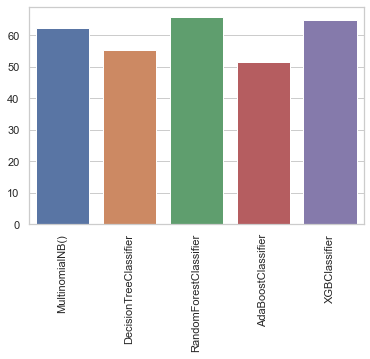

In [246]:
plt.xticks(rotation=90)
sns.barplot(x=Model,y=Acc_score)

In [249]:
#RandomForestClassifier
parameters={'n_estimators':[100,500,1000,2000],'max_features':['auto','sqrt'],'max_depth':range(5,20,3)}

from sklearn.model_selection import GridSearchCV
rfc=RandomForestClassifier(random_state=85)   #Using the best random state we obtained
rfc=GridSearchCV(rfc,parameters,cv=3,scoring='accuracy')
rfc.fit(x_train,y_train)
print(rfc.best_params_)     #Printing the best parameters obtained
print(rfc.best_score_)      #Mean cross-validated score of best_estimator

{'max_depth': 17, 'max_features': 'auto', 'n_estimators': 2000}
0.5659420289855073


In [250]:
#Using the best parameters obtained
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=85,stratify=y)
rfc=RandomForestClassifier(max_depth=17,max_features='auto',n_estimators=2000)
rfc.fit(x_train,y_train)
rfc_pred=rfc.predict(x_test)
print("Accuracy score: ",accuracy_score(y_test,rfc_pred)*100)
print('Cross validation score: ',cross_val_score(rfc,X,y,cv=3,scoring='accuracy').mean()*100)
print('Classification report: \n')
print(classification_report(y_test,rfc_pred))
print('Confusion matrix: \n')
print(confusion_matrix(y_test,rfc_pred))

Accuracy score:  59.233514935186925
Cross validation score:  40.5632159954368
Classification report: 

              precision    recall  f1-score   support

           1       0.62      0.68      0.65      1065
           2       0.48      0.70      0.57      1065
           3       0.69      0.34      0.45      1065
           4       0.60      0.49      0.54      1064
           5       0.66      0.76      0.70      1064

    accuracy                           0.59      5323
   macro avg       0.61      0.59      0.58      5323
weighted avg       0.61      0.59      0.58      5323

Confusion matrix: 

[[722 201  11  43  88]
 [145 747  46  85  42]
 [147 299 360 172  87]
 [120 151  76 520 197]
 [ 37 147  25  51 804]]


##### Since it didn’t show any improvement in result even after hyperparameter tuning. Hence, we will be choosing theRandomForestClassifier Model with default values that we got earlier.

#### Final Model

In [256]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=85,stratify=y)
RFC=RandomForestClassifier()
RFC.fit(x_train,y_train)
RFC_pred=RFC.predict(x_test)
print("Accuracy score: ",accuracy_score(y_test,RFC_pred)*100)
print('Cross validation score: ',cross_val_score(RFC,X,y,cv=3,scoring='accuracy').mean()*100)
print('Classification report: \n')
print(classification_report(y_test,RFC_pred))
print('Confusion matrix: \n')
print(confusion_matrix(y_test,RFC_pred))

Accuracy score:  65.95904565094871
Cross validation score:  43.696927492614385
Classification report: 

              precision    recall  f1-score   support

           1       0.61      0.79      0.69      1065
           2       0.80      0.62      0.70      1065
           3       0.70      0.48      0.57      1065
           4       0.57      0.57      0.57      1064
           5       0.67      0.84      0.75      1064

    accuracy                           0.66      5323
   macro avg       0.67      0.66      0.65      5323
weighted avg       0.67      0.66      0.65      5323

Confusion matrix: 

[[843  47  20  63  92]
 [172 659  86 104  44]
 [168  85 507 208  97]
 [151  20  79 607 207]
 [ 43  16  28  82 895]]


##### saving RandomForestCLassifier as the final model

In [ ]:
# Printing predicted values
pred_value=pd.DataFrame(data=y_test)
pred_value['Predicted values']=RFC_pred
pred_value

In [253]:
# Saving the best model.
import joblib

In [258]:
joblib.dump(RFC,'rating_Predict.pkl')

['rating_Predict.pkl']

In [263]:
# Saving the Predicted values in csv file
pred_value.to_csv('rating_Prediction.csv')